In [155]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

sns.set(style='dark', context='talk')
palette = sns.color_palette("GnBu_d")




In [156]:
data = pd.read_csv('cfs_2012_pumf_csv.txt')
print(data.shape)
data.head()


(4547661, 20)


,SHIPMT_ID,ORIG_STATE,ORIG_MA,ORIG_CFS_AREA,DEST_STATE,DEST_MA,DEST_CFS_AREA,NAICS,QUARTER,SCTG,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,TEMP_CNTL_YN,EXPORT_YN,EXPORT_CNTRY,HAZMAT,WGT_FACTOR
0,1,25,148,25-148,25,148,25-148,333,2,35,14,2178,11,14,17,N,N,N,N,208.5
1,2,42,428,42-428,6,41740,06-41740,311,3,35,14,344,11,2344,2734,N,N,N,N,193.3
2,3,26,220,26-220,47,314,47-314,322,2,27,4,4197,5134,470,579,N,N,N,N,51.2
3,4,20,556,20-556,20,556,20-556,323,1,29,4,116,6,3,3,N,N,N,N,238.7
4,5,12,99999,12-99999,12,99999,12-99999,4235,3,33,5,388,527,124,201,N,N,N,N,398.1


## Featuring Engineering

In [157]:
data.corr()

,SHIPMT_ID,ORIG_STATE,ORIG_MA,DEST_STATE,DEST_MA,NAICS,QUARTER,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,WGT_FACTOR
SHIPMT_ID,1.000000,0.000169,0.000288,-0.000182,0.000448,-0.000120,0.000054,-0.001140,0.000535,-0.000163,-0.000462,-0.000498,-0.000499
ORIG_STATE,0.000169,1.000000,0.054526,0.507648,0.028042,0.001577,0.000456,-0.017253,0.002470,0.013203,-0.033262,-0.029491,-0.005572
ORIG_MA,0.000288,0.054526,1.000000,0.026407,0.378136,-0.010465,0.006329,-0.073226,-0.002220,0.020197,-0.040448,-0.034713,-0.024695
DEST_STATE,-0.000182,0.507648,0.026407,1.000000,0.041635,-0.003382,0.001995,-0.024948,0.001516,0.005646,-0.056825,-0.051738,-0.002635
DEST_MA,0.000448,0.028042,0.378136,0.041635,1.000000,-0.003606,0.004708,-0.052183,-0.003937,0.002627,-0.060194,-0.061423,-0.009709
NAICS,-0.000120,0.001577,-0.010465,-0.003382,-0.003606,1.000000,-0.001581,0.005819,0.000586,0.000041,-0.012451,-0.012856,0.010893
QUARTER,0.000054,0.000456,0.006329,0.001995,0.004708,-0.001581,1.000000,-0.007362,0.000545,0.000543,-0.007935,-0.008187,-0.005600
MODE,-0.001140,-0.017253,-0.073226,-0.024948,-0.052183,0.005819,-0.007362,1.000000,-0.000079,0.009697,0.335222,0.347859,0.079089
SHIPMT_VALUE,0.000535,0.002470,-0.002220,0.001516,-0.003937,0.000586,0.000545,-0.000079,1.000000,0.105667,0.000968,0.001794,-0.001867
SHIPMT_WGHT,-0.000163,0.013203,0.020197,0.005646,0.002627,0.000041,0.000543,0.009697,0.105667,1.000000,-0.001638,0.002145,-0.004383


In [158]:
# transform NAICS values into 8 major categories: mining (except oil & gas), manufacturing, 
# wholesale, storage, fuel, online shopping, publishing, administration
def NAICS(x):
    if x >= 300 and x <= 400:
        return 'Manufacturing'
    elif x >= 4200 and x <= 4300:
        return 'Wholesale'
    elif x == 212:
        return 'Mining'
    elif x == 4541:
        return 'Online shopping'
    elif x == 45431:
        return 'Fuel'
    elif x == 4931:
        return 'Storage'
    elif x == 5111:
        return 'Publishing'
    else:
        return 'Administration'
    
data['NAICS_type'] = data['NAICS'].map(lambda x: NAICS(x))
data['NAICS_type'].value_counts()

Manufacturing      2149701
Wholesale          1882220
Mining              140933
Storage             101644
Fuel                101200
Online shopping      86257
Publishing           53137
Administration       32569
Name: NAICS_type, dtype: int64

In [159]:
# transform MODE values into 4 major categories:
def MODE(x):
    if x >= 3 and x <= 5:
        return 'Truck'
    elif x == 6:
        return 'Rail'
    elif x >= 7 and x <= 10 or x == 101:
        return 'Water'
    elif x == 11:
        return 'Air'
    elif x == 12:
        return 'Pipeline'
    elif x == 14:
        return 'Parcel'
    elif x == 15:
        return 'Truck and rail'
    else:
        return 'Other/multiple'

data['transportation_type'] = data['MODE'].map(lambda x: MODE(x))
data['transportation_type'].value_counts()
# data['MODE'].value_counts()

Truck             3231969
Parcel            1165297
Air                 68809
Rail                38458
Truck and rail      19070
Other/multiple      16489
Water                3896
Pipeline             3673
Name: transportation_type, dtype: int64

In [160]:
## extremely large shipment weight factors were truncated to 975000


truncated_weights = data[data['WGT_FACTOR'] == 975000]
print(truncated_weights.shape)
truncated_weights['SHIPMT_VALUE'].value_counts()

(1195, 22)


1      355
2       50
5       48
7       46
9       42
      ... 
178      1
182      1
199      1
210      1
103      1
Name: SHIPMT_VALUE, Length: 149, dtype: int64

In [161]:
data.groupby('transportation_type').agg({'SHIPMT_VALUE': 'mean'})

,SHIPMT_VALUE
transportation_type,
Air,1.734364e+05
Other/multiple,3.082203e+05
Parcel,1.772388e+03
Pipeline,1.701407e+06
Rail,1.252864e+05
Truck,1.459159e+04
Truck and rail,8.561352e+04
Water,1.074966e+06


In [162]:
## log transform shipment value

data['value_log'] = data['SHIPMT_VALUE'].map(lambda x: np.log(x))
data.groupby('transportation_type').agg({'value_log': 'mean'})

,value_log
transportation_type,
Air,7.327795
Other/multiple,8.603002
Parcel,5.359750
Pipeline,12.007496
Rail,10.552162
Truck,7.363319
Truck and rail,10.121477
Water,11.152365


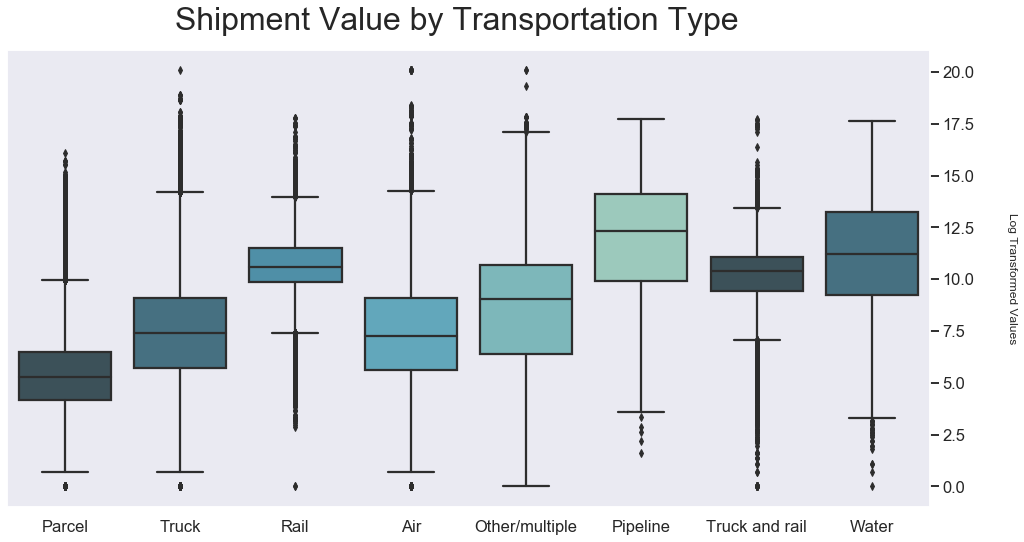

In [163]:
f, ax = plt.subplots(figsize=(14,8))
f.suptitle('Shipment Value by Transportation Type', ha='center', fontsize=32)
f.tight_layout(rect=[0, 0.03, 1, 0.95])

ax = sns.boxplot(x='transportation_type', y='value_log', data=data, palette=palette, showfliers=True)

ax.set_xlabel('')

ax.set_ylabel('Log Transformed Values', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()



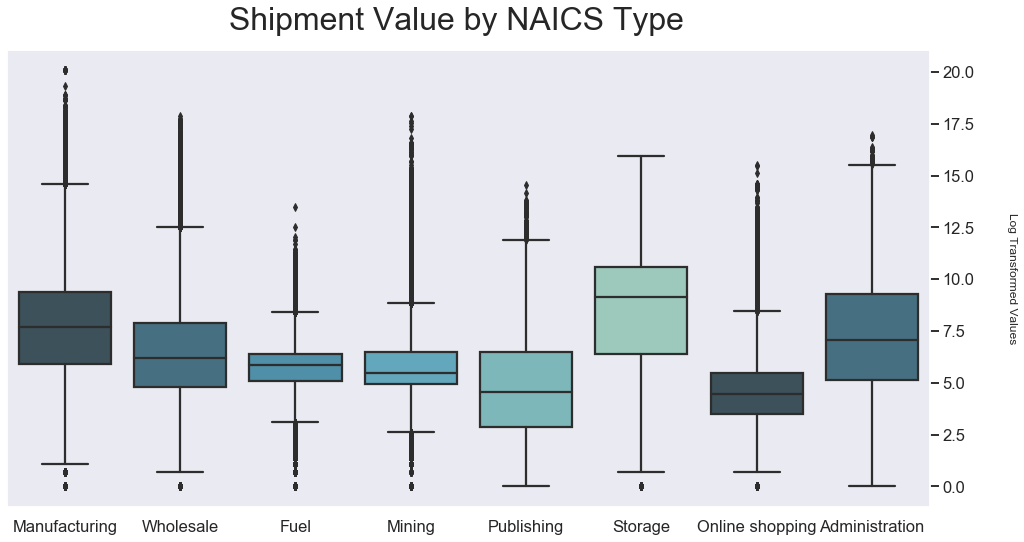

In [164]:
f, ax = plt.subplots(figsize=(14,8))
f.suptitle('Shipment Value by NAICS Type', ha='center', fontsize=32)
f.tight_layout(rect=[0, 0.03, 1, 0.95])

ax = sns.boxplot(x='NAICS_type', y='value_log', data=data, palette=palette, showfliers=True)

ax.set_xlabel('')

ax.set_ylabel('Log Transformed Values', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()



In [165]:
# def quantile_feature(feature, num_bins):
#     mean_over_feature = data.groupby(feature).agg({'SHIPMT_VALUE': 'mean'})
#     dest_state_quartiles = pd.DataFrame(pd.qcut(mean_over_feature['SHIPMT_VALUE'], num_bins))
#     dest_state_quartiles.rename(columns={'SHIPMT_VALUE': feature + '_QT'}, inplace=True)
#     data.merge(pd.DataFrame(dest_state_quartiles), left_on=feature, right_index=True)

# data = quantile_feature('ORIG_STATE', 4)
# data = quantile_feature('DEST_STATE', 4)
# data.head()

## ANOVA and Log Transformations

In [166]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

anova = ols('SHIPMT_VALUE~transportation_type',data=data).fit()
anova.summary()

## there are significant differences in the shipment values of different transportation types 
## large JB score indicates error not normally distributed

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SHIPMT_VALUE   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2274.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:52:36   Log-Likelihood:            -6.9645e+07
No. Observations:             4547661   AIC:                         1.393e+08
Df Residuals:                 4547653   BIC:                         1.393e+08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.734e+05   4130.013     41.994      0.000    1.65e+05    1.82e+05
transportation_type[T.Other/multiple]  1.348e+05   9393.419     14.349      0.000    1.16e+05    1.53e+05
transportation_type[T.Parcel]         -1.717e+05   4250.200    -40.390      0.000    -1.8e+05   -1.63e+05
transportation_type[T.Pipeline]        1.528e+06   1.83e+04     83.283      0.000    1.49e+06    1.56e+06
transportation_type[T.Rail]           -4.815e+04   6897.491     -6.981      0.000   -6.17e+04   -3.46e+04
transportation_type[T.Truck]          -1.588e+05   4173.746    -38.058      0.000   -1.67e+05   -1.51e+05
transportation_type[T.Truck and rail] -8.782e+04   8865.814     -9.906      0.000   -1.05e+05   -7.04e+04
transportation_type[T.Water]           9.015e+05   1.78e+04     50.531      0.000    8.67e+05    9.36e+05
================================================================================
Omnibus:                 27333656.233   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   7688714460228492.000
Skew:                         426.312   Prob(JB):                           0.00
Kurtosis:                  201437.825   Cond. No.                           47.5
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

((array([-5.12043185, -4.95057621, -4.85901244, ...,  4.85901244,
          4.95057621,  5.12043185]),
  array([-1.70140176e+06, -1.70139776e+06, -1.70139276e+06, ...,
          5.21104364e+08,  5.21104364e+08,  5.21263208e+08])),
 (60984.66135865332, 1.63529615333266e-08, 0.05629196388734975))

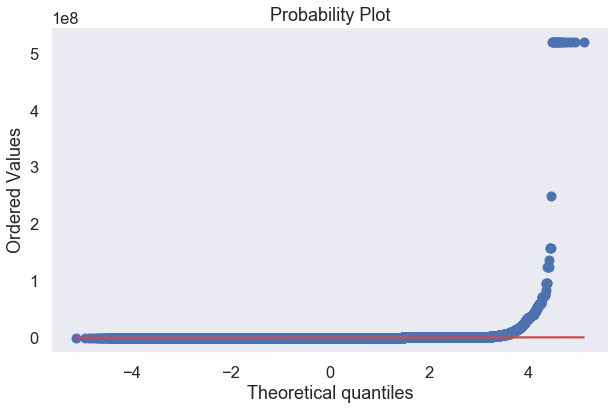

In [167]:
## qq plot without log values

pred_val = anova.fittedvalues.copy()
true_val = data['SHIPMT_VALUE'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(10,6))
sp.stats.probplot(residual, plot=ax, fit=True)

In [168]:
## same anova with log values

from statsmodels.formula.api import ols
import statsmodels.api as sm

anova = ols('value_log~transportation_type',data=data).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                 1.337e+05
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:53:35   Log-Likelihood:            -9.9709e+06
No. Observations:             4547661   AIC:                         1.994e+07
Df Residuals:                 4547653   BIC:                         1.994e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 7.3278      0.008    886.808      0.000       7.312       7.344
transportation_type[T.Other/multiple]     1.2752      0.019     67.852      0.000       1.238       1.312
transportation_type[T.Parcel]            -1.9680      0.009   -231.437      0.000      -1.985      -1.951
transportation_type[T.Pipeline]           4.6797      0.037    127.488      0.000       4.608       4.752
transportation_type[T.Rail]               3.2244      0.014    233.647      0.000       3.197       3.251
transportation_type[T.Truck]              0.0355      0.008      4.254      0.000       0.019       0.052
transportation_type[T.Truck and rail]     2.7937      0.018    157.495      0.000       2.759       2.828
transportation_type[T.Water]              3.8246      0.036    107.144      0.000       3.755       3.895
==============================================================================
Omnibus:                    11966.815   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11225.817
Skew:                          -0.095   Prob(JB):                         0.00
Kurtosis:                       2.847   Cond. No.                         47.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

((array([-5.12043185, -4.95057621, -4.85901244, ...,  4.85901244,
          4.95057621,  5.12043185]),
  array([-11.15236481, -10.5521619 , -10.5521619 , ...,  12.743999  ,
          12.743999  ,  12.743999  ])),
 (2.165711941323114, 1.2719714699137092e-11, 0.999158121065854))

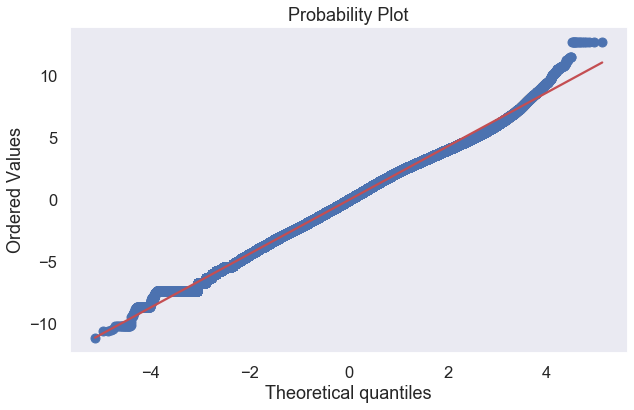

In [169]:
## qq plot with log values

pred_val = anova.fittedvalues.copy()
true_val = data['value_log'].values.copy()
residual = true_val - pred_val

f, ax = plt.subplots(figsize=(10,6))
sp.stats.probplot(residual, plot=ax, fit=True)

In [170]:
## log values regressed on NAICS type

from statsmodels.formula.api import ols
import statsmodels.api as sm

anova = ols('value_log~NAICS_type',data=data).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                 7.983e+04
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:54:31   Log-Likelihood:            -1.0133e+07
No. Observations:             4547661   AIC:                         2.027e+07
Df Residuals:                 4547653   BIC:                         2.027e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.1488      0.012    574.391      0.000       7.124       7.173
NAICS_type[T.Fuel]               -1.4063      0.014    -98.277      0.000      -1.434      -1.378
NAICS_type[T.Manufacturing]       0.4350      0.013     34.687      0.000       0.410       0.460
NAICS_type[T.Mining]             -1.2286      0.014    -88.970      0.000      -1.256      -1.202
NAICS_type[T.Online shopping]    -2.5340      0.015   -173.468      0.000      -2.563      -2.505
NAICS_type[T.Publishing]         -2.4163      0.016   -152.868      0.000      -2.447      -2.385
NAICS_type[T.Storage]             1.2725      0.014     88.978      0.000       1.244       1.301
NAICS_type[T.Wholesale]          -0.8161      0.013    -65.013      0.000      -0.841      -0.792
==============================================================================
Omnibus:                     4079.258   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3760.341
Skew:                          -0.041   Prob(JB):                         0.00
Kurtosis:                       2.885   Cond. No.                         40.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
## two way anova with NAICS type and transportation type

from statsmodels.formula.api import ols
import statsmodels.api as sm

# formula = 'value_log~NAICS_type~C():C(transportation_type)'
anova_two = ols(formula='value_log~C(NAICS_type):C(transportation_type)', data = data).fit()
anova_two_table = sm.stats.anova_lm(anova_two, typ=2)
anova_two.summary()

/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 54
  'rank is %d' % (J, J_), ValueWarning)
/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 3.435e+04
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:59:36   Log-Likelihood:            -9.6185e+06
No. Observations:             4547661   AIC:                         1.924e+07
Df Residuals:                 4547606   BIC:                         1.924e+07
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   7.2017      0.070    102.241      0.000       7.064       7.340
C(transportation_type)[T.Other/multiple]                                    1.6944      0.166     10.205      0.000       1.369       2.020
C(transportation_type)[T.Parcel]                                           -1.9060      0.073    -26.062      0.000      -2.049      -1.763
C(transportation_type)[T.Pipeline]                                          6.5966      0.185     35.712      0.000       6.235       6.959
C(transportation_type)[T.Rail]                                              3.2344      0.141     22.916      0.000       2.958       3.511
C(transportation_type)[T.Truck]                                             0.7510      0.072     10.458      0.000       0.610       0.892
C(transportation_type)[T.Truck and rail]                                    1.8728      0.197      9.511      0.000       1.487       2.259
C(transportation_type)[T.Water]                                             4.8695      0.247     19.741      0.000       4.386       5.353
C(NAICS_type)[T.Fuel]:C(transportation_type)[Air]                       -1.514e-13   9.17e-15    -16.512      0.000   -1.69e-13   -1.33e-13
C(NAICS_type)[T.Manufacturing]:C(transportation_type)[Air]                  0.4354      0.071      6.127      0.000       0.296       0.575
C(NAICS_type)[T.Mining]:C(transportation_type)[Air]                         4.9417      0.454     10.884      0.000       4.052       5.832
C(NAICS_type)[T.Online shopping]:C(transportation_type)[Air]               -2.2332      0.089    -25.006      0.000      -2.408      -2.058
C(NAICS_type)[T.Publishing]:C(transportation_type)[Air]                    -3.0554      0.110    -27.882      0.000      -3.270      -2.841
C(NAICS_type)[T.Storage]:C(transportation_type)[Air]                       -0.1717      0.090     -1.913      0.056      -0.348       0.004
C(NAICS_type)[T.Wholesale]:C(transportation_type)[Air]                     -0.3399      0.072     -4.726      0.000      -0.481      -0.199
C(NAICS_type)[T.Fuel]:C(transportation_type)[Other/multiple]               -4.1634      0.307    -13.546      0.000      -4.766      -3.561
C(NAICS_type)[T.Manufacturing]:C(transportation_type)[Other/multiple]       0.1259      0.152      0.829      0.407      -0.172       0.424
C(NAICS_type)[T.Mining]:C(transportation_type)[Other/multiple]              0.2474      0.161      1.537      0.124      -0.068       0.563
C(NAICS_type)[T.Online shopping]:C(transportation_type)[Other/multiple]    -4.4153      0.220    -20.104      0.000      -4.846      -3.985
C(N

## Post-Hoc Test 

In [177]:
## Tukey HSD comparing dependent variable in last anova test

mc = statsmodels.stats.multicomp.MultiComparison(data['value_log'], data['NAICS_type'])
result = mc.tukeyhsd()

result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])

result_df.columns = ['Group 1', 'Group 2', 'Mean Difference', 'p-adj', '95% CI Lower-Bound', '95% CI Upper-Bound', 'Reject Null']
result_df


,Group 1,Group 2,Mean Difference,p-adj,95% CI Lower-Bound,95% CI Upper-Bound,Reject Null
0,Administration,Fuel,-1.4063,0.001,-1.4496,-1.3629,True
1,Administration,Manufacturing,0.4350,0.001,0.3970,0.4730,True
2,Administration,Mining,-1.2286,0.001,-1.2705,-1.1868,True
3,Administration,Online shopping,-2.5340,0.001,-2.5783,-2.4897,True
4,Administration,Publishing,-2.4163,0.001,-2.4642,-2.3684,True
5,Administration,Storage,1.2725,0.001,1.2292,1.3159,True
6,Administration,Wholesale,-0.8161,0.001,-0.8542,-0.7781,True
7,Fuel,Manufacturing,1.8412,0.001,1.8193,1.8631,True
8,Fuel,Mining,0.1776,0.001,0.1496,0.2057,True
9,Fuel,Online shopping,-1.1277,0.001,-1.1593,-1.0962,True


## Examining Regression Coefficients

In [178]:
## run regression on raw data
## shows results are significant but small R-squared value

lr_model = ols(formula='SHIPMT_VALUE~SHIPMT_WGHT+SHIPMT_DIST_ROUTED', data=data).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SHIPMT_VALUE   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 2.568e+04
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:00:00   Log-Likelihood:            -6.9628e+07
No. Observations:             4547661   AIC:                         1.393e+08
Df Residuals:                 4547658   BIC:                         1.393e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.264e+04    615.551     20.535      0.000    1.14e+04    1.38e+04
SHIPMT_WGHT            0.1187      0.001    226.598      0.000       0.118       0.120
SHIPMT_DIST_ROUTED     2.4765      0.737      3.361      0.001       1.033       3.920
================================================================================
Omnibus:                 27403005.295   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   7918399799053278.000
Skew:                         430.505   Prob(JB):                           0.00
Kurtosis:                  204424.438   Cond. No.                       1.18e+06
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [179]:
## transform shipment weight and distance travelled into log

data['weight_log'] = data['SHIPMT_WGHT'].map(lambda x: np.log(x))
data['dist_log'] = data['SHIPMT_DIST_ROUTED'].map(lambda x: np.log(x))


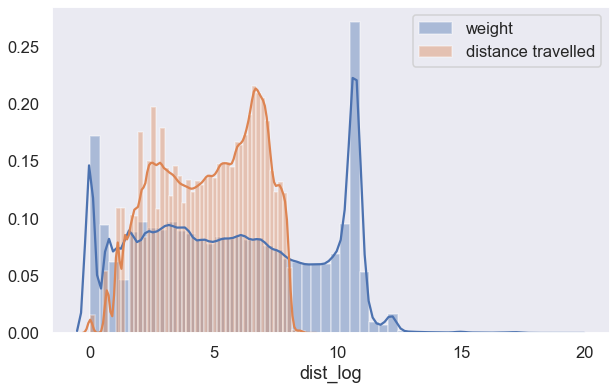

In [180]:
## plot the logged values

f, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(data.weight_log, label = 'weight')
ax = sns.distplot(data.dist_log, label='distance travelled')
ax.legend()

In [181]:
## run regression on continuous variables after log transformations
## r-squared has improved a lot

lr_model = ols(formula='value_log~weight_log+dist_log', data=data).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 3.076e+06
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:00:24   Log-Likelihood:            -8.4507e+06
No. Observations:             4547661   AIC:                         1.690e+07
Df Residuals:                 4547658   BIC:                         1.690e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6936      0.002   1145.824      0.000       2.689       2.698
weight_log     0.5012      0.000   2438.893      0.000       0.501       0.502
dist_log       0.2799      0.000    759.342      0.000       0.279       0.281
==============================================================================
Omnibus:                    88209.923   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189981.325
Skew:                           0.022   Prob(JB):                         0.00
Kurtosis:                       4.000   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
## add categorical variables to model
## r-squared improves

lr_model = ols(formula='value_log~weight_log+dist_log+NAICS_type+transportation_type', data=data).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 5.267e+05
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:01:14   Log-Likelihood:            -8.0125e+06
No. Observations:             4547661   AIC:                         1.603e+07
Df Residuals:                 4547644   BIC:                         1.603e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 4.6419      0.010    474.518      0.000       4.623       4.661
NAICS_type[T.Fuel]                       -1.4496      0.009   -160.729      0.000      -1.467      -1.432
NAICS_type[T.Manufacturing]              -0.1674      0.008    -21.270      0.000      -0.183      -0.152
NAICS_type[T.Mining]                     -3.7745      0.009   -431.203      0.000      -3.792      -3.757
NAICS_type[T.Online shopping]            -0.7919      0.009    -85.928      0.000      -0.810      -0.774
NAICS_type[T.Publishing]                 -1.2835      0.010   -129.298      0.000      -1.303      -1.264
NAICS_type[T.Storage]                     0.3394      0.009     37.785      0.000       0.322       0.357
NAICS_type[T.Wholesale]                  -0.4252      0.008    -53.944      0.000      -0.441      -0.410
transportation_type[T.Other/multiple]    -1.1827      0.012    -96.153      0.000      -1.207      -1.159
transportation_type[T.Parcel]            -1.2000      0.006   -216.469      0.000      -1.211      -1.189
transportation_type[T.Pipeline]          -0.0999      0.024     -4.148      0.000      -0.147      -0.053
transportation_type[T.Rail]              -1.0807      0.009   -116.509      0.000      -1.099      -1.063
transportation_type[T.Truck]             -1.4146      0.006   -251.264      0.000      -1.426      -1.404
transportation_type[T.Truck and rail]    -1.0760      0.012    -92.053      0.000      -1.099      -1.053
transportation_type[T.Water]             -0.3472      0.023    -14.860      0.000      -0.393      -0.301
weight_log                                0.5427      0.000   2074.087      0.000       0.542       0.543
dist_log                                  0.1899      0.000    479.191      0.000       0.189       0.191
==============================================================================
Omnibus:                   173468.350   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           412340.558
Skew:                           0.217   Prob(JB):                         0.00
Kurtosis:                       4.410   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interactions

In [183]:
def NAICS_int(x):
    if x == 'Manufacturing':
        return 0
    elif x == 'Wholesale':
        return 1
    elif x == 'Mining':
        return 2
    elif x == 'Online shopping':
        return 3
    elif x == 'Fuel':
        return 4
    elif x == 'Storage':
        return 5
    elif x == 'Publishing':
        return 6
    else:
        return 7
    
NAICS_interact['NAICS_int'] = data['NAICS_type'].map(lambda x: NAICS_int(x))
NAICS_interact['NAICS_int'].value_counts()

0    2149701
1    1882220
2     140933
5     101644
4     101200
3      86257
6      53137
7      32569
Name: NAICS_int, dtype: int64

In [184]:
# NAICS_interact = data[['NAICS_type', 'weight_log']]
NAICS_interact['NAICS_and_weight'] = NAICS_interact['NAICS_int'] * NAICS_interact['weight_log']
# NAICS_interact = sm.add_constant(NAICS_interact)
interact_model = sm.OLS(data['value_log'], NAICS_interact).fit()

interact_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                 1.750e+06
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:01:19   Log-Likelihood:            -8.6508e+06
No. Observations:             4547661   AIC:                         1.730e+07
Df Residuals:                 4547657   BIC:                         1.730e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
NAICS_type           0.6243      0.000   2487.283      0.000       0.624       0.625
weight_log           0.4747      0.000   1858.742      0.000       0.474       0.475
NAICS_int           -0.2377      0.001   -216.016      0.000      -0.240      -0.236
NAICS_and_weight     0.0024      0.000     14.213      0.000       0.002       0.003
==============================================================================
Omnibus:                    78634.359   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159584.921
Skew:                           0.041   Prob(JB):                         0.00
Kurtosis:                       3.914   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
## interaction plot

# fig = interaction_plot(x = flight_weather_precip.origin, 
#                        trace = flight_weather_precip.precip_type, 
#                        response = flight_weather_precip.dep_delay, 
#                        colors = ['red', 'blue', 'green', 'orange'], ms=10)

## Polynomial Regression

In [186]:
## create new series with squared weight_log and squared dist_log

data['weight_log_squared'] = data['weight_log'] **2
data['dist_log_squared'] = data['dist_log'] **2

In [187]:
## run polynomial regression on both

polyreg = ols(formula="value_log~weight_log+weight_log_squared", data=data).fit()
polyreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                 2.478e+06
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:01:22   Log-Likelihood:            -8.7203e+06
No. Observations:             4547661   AIC:                         1.744e+07
Df Residuals:                 4547658   BIC:                         1.744e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0538      0.002   1993.313      0.000       4.050       4.058
weight_log             0.5287      0.001    659.002      0.000       0.527       0.530
weight_log_squared    -0.0041   6.61e-05    -61.345      0.000      -0.004      -0.004
==============================================================================
Omnibus:                    71099.663   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           140651.399
Skew:                          -0.010   Prob(JB):                         0.00
Kurtosis:                       3.861   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
polyreg = ols(formula="value_log~dist_log+dist_log_squared", data=data).fit()
polyreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                 7.748e+04
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:01:24   Log-Likelihood:            -1.0320e+07
No. Observations:             4547661   AIC:                         2.064e+07
Df Residuals:                 4547658   BIC:                         2.064e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.8239      0.006    832.574      0.000       4.813       4.835
dist_log             0.8659      0.003    309.410      0.000       0.860       0.871
dist_log_squared    -0.0769      0.000   -255.379      0.000      -0.077      -0.076
==============================================================================
Omnibus:                    20348.353   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15028.142
Skew:                           0.020   Prob(JB):                         0.00
Kurtosis:                       2.721   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ridge and Lasso

In [189]:
X = pd.concat([pd.get_dummies(data['NAICS_type']), pd.get_dummies(data['transportation_type']), 
               data['weight_log'], data['dist_log']], ignore_index=True, axis=1)


y = data['value_log']

In [190]:
## Ridge regression with grid search to find best hyperparameter value

alphas = np.array([5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001, 0 ])

model = Ridge()
ridge = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
ridge.fit(X, y)

print("Ridge Regression best estimator is: {}".format(ridge.best_estimator_.alpha))
print("Ridge Regression R-squared is: {}".format(ridge.best_score_))
# print("Ridge Linear Regression Intercept:{}".format(model.intercept_))

/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Ridge Regression best estimator is: 1.0
Ridge Regression R-squared is: 0.6494876016370738


In [191]:
## lasso regression removes most features and doesn't improve R-squared

lasso = Lasso(alpha=1.0)
lasso.fit(X, y)
print("Lasso Regression coefficients are: {}".format(lasso.coef_))
print("Lasso Regression R-squared is: {}".format(lasso.score(X, y)))


Lasso Regression coefficients are: [ 0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.          0.          0.4031593   0.00498664]
Lasso Regression R-squared is: 0.5091518219217137


## Validation

In [192]:
## this is the best model:

lr_model = ols(formula='value_log~weight_log+dist_log+NAICS_type+transportation_type', data=data).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 5.267e+05
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:03:05   Log-Likelihood:            -8.0125e+06
No. Observations:             4547661   AIC:                         1.603e+07
Df Residuals:                 4547644   BIC:                         1.603e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 4.6419      0.010    474.518      0.000       4.623       4.661
NAICS_type[T.Fuel]                       -1.4496      0.009   -160.729      0.000      -1.467      -1.432
NAICS_type[T.Manufacturing]              -0.1674      0.008    -21.270      0.000      -0.183      -0.152
NAICS_type[T.Mining]                     -3.7745      0.009   -431.203      0.000      -3.792      -3.757
NAICS_type[T.Online shopping]            -0.7919      0.009    -85.928      0.000      -0.810      -0.774
NAICS_type[T.Publishing]                 -1.2835      0.010   -129.298      0.000      -1.303      -1.264
NAICS_type[T.Storage]                     0.3394      0.009     37.785      0.000       0.322       0.357
NAICS_type[T.Wholesale]                  -0.4252      0.008    -53.944      0.000      -0.441      -0.410
transportation_type[T.Other/multiple]    -1.1827      0.012    -96.153      0.000      -1.207      -1.159
transportation_type[T.Parcel]            -1.2000      0.006   -216.469      0.000      -1.211      -1.189
transportation_type[T.Pipeline]          -0.0999      0.024     -4.148      0.000      -0.147      -0.053
transportation_type[T.Rail]              -1.0807      0.009   -116.509      0.000      -1.099      -1.063
transportation_type[T.Truck]             -1.4146      0.006   -251.264      0.000      -1.426      -1.404
transportation_type[T.Truck and rail]    -1.0760      0.012    -92.053      0.000      -1.099      -1.053
transportation_type[T.Water]             -0.3472      0.023    -14.860      0.000      -0.393      -0.301
weight_log                                0.5427      0.000   2074.087      0.000       0.542       0.543
dist_log                                  0.1899      0.000    479.191      0.000       0.189       0.191
==============================================================================
Omnibus:                   173468.350   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           412340.558
Skew:                           0.217   Prob(JB):                         0.00
Kurtosis:                       4.410   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
## validate with train test split 
## we don't need to cross validate because we have a lot of data

# X = data[['weight_log', 'dist_log', 'NAICS_type', 'transportation_type']]
X = pd.concat([pd.get_dummies(data['NAICS_type']), pd.get_dummies(data['transportation_type']), 
               data['weight_log'], data['dist_log']], ignore_index=True, axis=1)
y = data[['value_log']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

3638128 909533 3638128 909533


In [197]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [198]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [200]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)

Train Mean Squared Error: value_log    1.984468
dtype: float64
Test Mean Squared Error: value_log    1.990008
dtype: float64


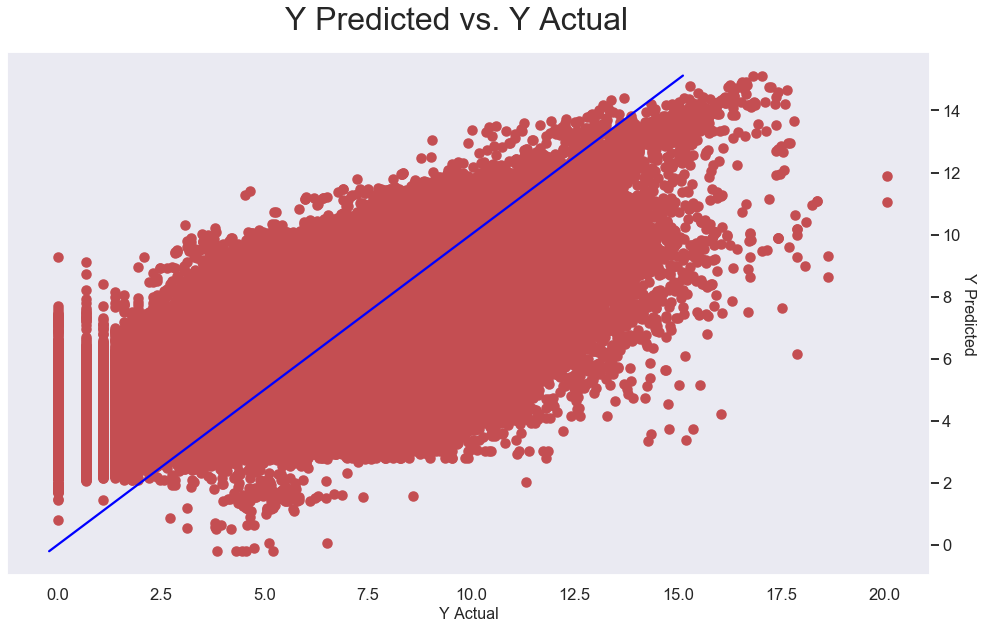

In [227]:
y_hat_test = linreg.predict(X_test)

f, ax = plt.subplots(figsize=(14, 9))
f.suptitle('Y Predicted vs. Y Actual', ha='center', fontsize=32)
f.tight_layout(rect=[0, 0.03, 1, 0.95])


# ax = sns.scatterplot(y_test, y_hat_test)
plt.scatter(y_test, y_hat_test, c='r')

ax.set_xlabel('Y Actual', fontsize=16)
ax.set_ylabel('Y Predicted', rotation=270, fontsize=16)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.050, 0.5)
ax.yaxis.tick_right()

lineStart = y_hat_test.min()
lineEnd = y_hat_test.max()
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'blue')

plt.show()


In [ ]:
## check for interactions 

## cross validate 
## k-fold
## plot regression

## assumptions
## validation


In [ ]:
## describe the process of trying ANOVA tests
## discuss the limitations of your results
## tried Tukey
## ran regression on continuous variables
## ran regression on transformed continuous variables
## ran regression on transformed continuous variables with categorical variables 


## graphs 
## plot value by other features

## look at export country
## look at quarter 

## look at SCTG 


In [ ]:
# X = pd.concat([pd.get_dummies(data['NAICS_type']), pd.get_dummies(data['transportation_type']), 
#                data['SHIPMT_WGHT'], data['SHIPMT_DIST_ROUTED']], ignore_index=True, axis=1)

# # min_max_scaler = preprocessing.MinMaxScaler()
# # y = min_max_scaler.fit_transform(data['SHIPMT_VALUE'].values.reshape(-1,1))
# y = data['SHIPMT_VALUE']

# model = LinearRegression()
# model.fit(X, y)
# print(model.score(X, y))
# model.coef_